# Workflow

Imports
Load in data
drop NaN
extract summary stats (dpm = diff per minute) for games and create game_stats dataframe
convert dtypes
construct rolling averages


In [1]:
# Imports

import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import pickle 
import numpy as np
import matplotlib.pyplot as plt


from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 60)

In [2]:
# Load the npy file produced in the data collection notebook
with open('../../Data collection/ProPlay/game_data.pkl', 'rb') as f:
    game_data = pickle.load(f)

In [3]:
game_numbers = list(game_data.keys())


In [4]:
all_matches_dfs = [game_data[num]['data'] for num in game_numbers]
all_matches_df = pd.concat(all_matches_dfs)

# When we preview the df we see that there are many NaN columns
all_matches_df.head(20)

,Player,Level,Kills,Deaths,Assists,KDA,CS,CS in Team's Jungle,CS in Enemy Jungle,CSM,Golds,GPM,GOLD%,Vision Score,Wards placed,Wards destroyed,Control Wards Purchased,Detector Wards Placed,VSPM,WPM,VWPM,WCPM,VS%,Total damage to Champion,Physical Damage,Magic Damage,True Damage,DPM,DMG%,K+A Per Minute,KP%,Solo kills,Double kills,Triple kills,Quadra kills,Penta kills,GD@15,CSD@15,XPD@15,LVLD@15,Objectives Stolen,Damage dealt to turrets,Damage dealt to buildings,Total heal,Total Heals On Teammates,Damage self mitigated,Total Damage Shielded On Teammates,Time ccing others,Total Time CC Dealt,Total damage taken,Total Time Spent Dead,Consumables purchased,Items Purchased,Shutdown bounty collected,Shutdown bounty lost
Role,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BLUE_TOP,Cola,NaN,0.0,4.0,1.0,0.3,152.0,8.0,3.0,6.2,6326.0,258.0,20.7,NaN,11.0,1.0,1.0,NaN,NaN,0.45,0.04,0.04,NaN,4015.0,252.0,3763.0,0.0,164.0,18.4,0.04,100.0,NaN,0.0,0.0,0.0,0.0,-1151.0,-10.0,-801.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BLUE_JNG,inSec,NaN,0.0,4.0,0.0,0,115.0,78.0,2.0,4.7,5964.0,243.0,19.5,NaN,10.0,5.0,2.0,NaN,NaN,0.41,0.08,0.20,NaN,3866.0,3411.0,0.0,455.0,158.0,17.7,0.00,0.0,NaN,0.0,0.0,0.0,0.0,-886.0,23.0,352.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BLUE_MID,Corn,NaN,1.0,4.0,0.0,0.3,192.0,27.0,0.0,7.8,7062.0,288.0,23.1,NaN,9.0,2.0,2.0,NaN,NaN,0.37,0.08,0.08,NaN,6195.0,359.0,5836.0,0.0,253.0,28.4,0.04,100.0,NaN,0.0,0.0,0.0,0.0,-1734.0,-10.0,-962.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BLUE_ADC,Uzi,NaN,0.0,2.0,1.0,0.5,168.0,12.0,0.0,6.8,6940.0,283.0,22.7,NaN,5.0,2.0,1.0,NaN,NaN,0.20,0.04,0.08,NaN,5449.0,2368.0,2657.0,424.0,222.0,24.9,0.04,100.0,NaN,0.0,0.0,0.0,0.0,-412.0,-2.0,-3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BLUE_SUP,Zero,NaN,0.0,2.0,1.0,0.5,5.0,0.0,0.0,0.2,4306.0,176.0,14.1,NaN,24.0,4.0,6.0,NaN,NaN,0.98,0.24,0.16,NaN,2319.0,601.0,1458.0,260.0,95.0,10.6,0.04,100.0,NaN,0.0,0.0,0.0,0.0,-701.0,-12.0,-415.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RED_TOP,Looper,NaN,3.0,0.0,8.0,Perfect KDA,193.0,0.0,0.0,7.9,10492.0,428.0,21.3,NaN,8.0,5.0,2.0,NaN,NaN,0.33,0.08,0.20,NaN,6715.0,837.0,5878.0,0.0,274.0,17.8,0.45,68.8,NaN,0.0,0.0,0.0,0.0,1151.0,10.0,801.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RED_JNG,DanDy,NaN,5.0,0.0,9.0,Perfect KDA,83.0,59.0,11.0,3.4,9692.0,395.0,19.6,NaN,10.0,6.0,5.0,NaN,NaN,0.41,0.20,0.24,NaN,6506.0,5263.0,968.0,275.0,265.0,17.3,0.57,87.5,NaN,0.0,0.0,0.0,0.0,886.0,-23.0,-352.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RED_MID,PawN,NaN,7.0,0.0,7.0,Perfect KDA,230.0,6.0,9.0,9.4,12507.0,510.0,25.4,NaN,16.0,6.0,1.0,NaN,NaN,0.65,0.04,0.24,NaN,11460.0,10913.0,457.0,90.0,467.0,30.4,0.57,87.5,NaN,1.0,0.0,0.0,0.0,1734.0,10.0,962.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RED_ADC,imp,NaN,1.0,0.0,7.0,Perfect KDA,163.0,3.0,2.0,6.6,9507.0,388.0,19.3,NaN,7.0,2.0,2.0,NaN,NaN,0.29,0.08,0.08,NaN,10293.0,9091.0,0.0,1202.0,420.0,27.3,0.33,50.0,NaN,0.0,0.0,0.0,0.0,412.0,2.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Drop all the columns which have NaN, and store the remaining columns in a good_cols list
good_data_df = all_matches_df.dropna(axis = 'columns').copy()
good_cols = list(good_data_df.columns)
good_cols = [col for col in good_cols if col not in ('Player','Deaths', 'KDA', 'CSM', 'GPM', 'DPM', 'WPM', 'VWPM', 'WCPM','K+A Per Minute', 'GOLD%', 'DMG%', 'KP%')]
good_cols

['Kills',
 'Assists',
 'CS',
 'Golds',
 'Total damage to Champion',
 'Physical Damage',
 'Magic Damage',
 'True Damage']

In [6]:
good_data_df[good_cols]

,Kills,Assists,CS,Golds,Total damage to Champion,Physical Damage,Magic Damage,True Damage
Role,,,,,,,,
BLUE_TOP,0.0,1.0,152.0,6326.0,4015.0,252.0,3763.0,0.0
BLUE_JNG,0.0,0.0,115.0,5964.0,3866.0,3411.0,0.0,455.0
BLUE_MID,1.0,0.0,192.0,7062.0,6195.0,359.0,5836.0,0.0
BLUE_ADC,0.0,1.0,168.0,6940.0,5449.0,2368.0,2657.0,424.0
BLUE_SUP,0.0,1.0,5.0,4306.0,2319.0,601.0,1458.0,260.0
...,...,...,...,...,...,...,...,...
RED_TOP,0.0,9.0,243.0,11057.0,9422.0,3305.0,6117.0,0.0
RED_JNG,2.0,8.0,180.0,10558.0,11523.0,979.0,10336.0,208.0
RED_MID,5.0,3.0,341.0,14984.0,24693.0,643.0,23203.0,847.0


In [7]:
# Useful little function to convert minutes and seconds to seconds
def get_sec(time_str):
    """Get seconds from minutes and seconds."""
    m, s = time_str.split(':')
    return int(m) * 60 + int(s)

In [129]:
def extract_gamestats(game_number):
    '''
    Extracts game data from a single game which consists of a dictionary with keys 'metadata' and 'data'.
    
    '''
    game = game_data[game_number]
    
    game_stats = {}
    
    metadata = game['metadata']
    data = game['data']
    

    
    game_stats['GAME_NUMBER'] = int(game_number)
    game_stats['DATE'] = metadata['DATE']
    game_stats['PATCH'] = metadata['PATCH']
    game_stats['BLUE_TEAM'] = metadata['BLUE_TEAM']
    game_stats['RED_TEAM'] = metadata['RED_TEAM']
    game_stats['GAME_WINNER'] = metadata['GAME_WINNER']
    game_stats['MATCH_WINNER'] = metadata['MATCH_WINNER']
    game_length = get_sec(metadata['GAME_LENGTH'])
    game_stats['GAME_LENGTH'] = game_length
    
    for col in good_cols:
        game_stats[f'{col}_pm_BLUE'] = data[col][0:5].sum() / (game_length/60)
        game_stats[f'{col}_pm_RED'] = data[col][5:].sum() / (game_length/60)
    

    
#    game_stats['games_in_match'] = metadata['GAMES_IN_MATCH']
#    game_stats['MATCH_SCORE'] = metadata['MATCH_SCORE']
    
#    game_stats['GD'] = data['Golds'][0:5].sum() - data['Golds'][5:].sum()
#    game_stats['GD@15'] = data['GD@15'][0:5].sum()
    
#    game_stats['GPMD'] = data['GPM'][0:5].sum() - data['GPM'][5:].sum()
#    game_stats['CSMD'] = data['CSM'][0:5].sum() - data['CSM'][5:].sum()
    
#    game_stats['BLUE_kills'] = data['Kills'][0:5].sum()
#    game_stats['BLUE_deaths'] = data['Kills'][5:].sum()
#    game_stats['RED_kills'] = data['Deaths'][0:5].sum()
#    game_stats['RED_deaths'] = data['Deaths'][5:].sum()
    

    
    return game_stats
    

In [130]:
%%time
# Construct a dictionary and dataframe, where each row is a match and the columns are given by the function extract_gamestats
df_dict = [extract_gamestats(num) for num in game_numbers]

df =  pd.DataFrame(df_dict)
df = df.set_index('GAME_NUMBER')

Wall time: 696 ms


In [131]:
df

,DATE,PATCH,BLUE_TEAM,RED_TEAM,GAME_WINNER,MATCH_WINNER,GAME_LENGTH,Kills_pm_BLUE,Kills_pm_RED,Assists_pm_BLUE,Assists_pm_RED,CS_pm_BLUE,CS_pm_RED,Golds_pm_BLUE,Golds_pm_RED,Total damage to Champion_pm_BLUE,Total damage to Champion_pm_RED,Physical Damage_pm_BLUE,Physical Damage_pm_RED,Magic Damage_pm_BLUE,Magic Damage_pm_RED,True Damage_pm_BLUE,True Damage_pm_RED
GAME_NUMBER,,,,,,,,,,,,,,,,,,,,,,,
257,2014-10-19,4.14,Star Horn Royal Club,Samsung Galaxy White,Samsung Galaxy White,Samsung Galaxy White,1472,0.040761,0.652174,0.122283,1.711957,25.760870,28.206522,1247.201087,2010.570652,890.380435,1535.828804,284.959239,1078.614130,558.994565,383.804348,46.426630,73.410326
258,2014-10-19,4.14,Samsung Galaxy White,Star Horn Royal Club,Samsung Galaxy White,Samsung Galaxy White,1756,0.888383,0.273349,1.879271,0.546697,28.462415,25.182232,2027.835991,1352.494305,2277.710706,1267.961276,1517.152620,599.419134,669.977221,624.635535,90.580866,43.906606
259,2014-10-19,4.14,Star Horn Royal Club,Samsung Galaxy White,Star Horn Royal Club,Samsung Galaxy White,2313,0.492866,0.363165,1.400778,0.985733,27.937743,27.600519,1785.629053,1516.601816,1787.937743,1768.378729,442.360571,764.176394,1307.548638,854.837873,38.028534,149.364462
260,2014-10-19,4.14,Samsung Galaxy White,Star Horn Royal Club,Samsung Galaxy White,Samsung Galaxy White,1379,0.826686,0.217549,2.306019,0.217549,30.413343,26.236403,2019.767948,1344.365482,1937.751994,1033.531545,671.921682,422.218999,1208.484409,574.111675,57.345903,37.200870
252,2014-10-12,4.14,Star Horn Royal Club,OMG,OMG,Star Horn Royal Club,1762,0.238365,0.783201,0.510783,1.872872,22.542565,26.492622,1291.123723,2034.858116,1267.253121,2576.901249,526.072645,1547.026107,668.206583,976.106697,72.973893,53.768445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44341,2022-10-07,12.18,T1,Edward Gaming,T1,T1,1371,0.787746,0.262582,2.231947,0.656455,31.203501,27.133479,1993.566740,1608.358862,2416.673961,2065.908096,1138.730853,792.472648,1079.518600,1008.315098,198.424508,265.120350
44340,2022-10-07,12.18,JD Gaming,Evil Geniuses,JD Gaming,JD Gaming,1786,0.806271,0.470325,2.150056,1.142217,31.511758,29.294513,2033.045913,1668.812990,2238.275476,2169.876820,1229.697648,1122.765957,912.329227,938.465845,96.248600,108.645017
44339,2022-10-07,12.18,CTBC Flying Oyster,100 Thieves,CTBC Flying Oyster,CTBC Flying Oyster,1911,0.502355,0.282575,1.036107,0.596546,33.940345,31.459969,1957.676609,1653.343799,1893.406593,1587.221350,901.601256,869.105181,859.686028,525.934066,132.119309,192.182104


In [132]:
# Convert dtypes
df['DATE'] = pd.to_datetime(df['DATE'])

# Add codes for categorical data
# 1 for blue win, 0 for red win
df['BLUEWIN'] = np.where(df['BLUE_TEAM'] == df['GAME_WINNER'], 1, 0)

# 
team_codes = df.BLUE_TEAM.astype('category').cat.codes
teams = ['BLUE_TEAM','RED_TEAM']
df[['BLUE_TEAM_CODES', 'RED_TEAM_CODES']] = (pd.factorize(df[teams].values.ravel())[0]+1).reshape(-1, len(teams))

In [133]:
df

,DATE,PATCH,BLUE_TEAM,RED_TEAM,GAME_WINNER,MATCH_WINNER,GAME_LENGTH,Kills_pm_BLUE,Kills_pm_RED,Assists_pm_BLUE,Assists_pm_RED,CS_pm_BLUE,CS_pm_RED,Golds_pm_BLUE,Golds_pm_RED,Total damage to Champion_pm_BLUE,Total damage to Champion_pm_RED,Physical Damage_pm_BLUE,Physical Damage_pm_RED,Magic Damage_pm_BLUE,Magic Damage_pm_RED,True Damage_pm_BLUE,True Damage_pm_RED,BLUEWIN,BLUE_TEAM_CODES,RED_TEAM_CODES
GAME_NUMBER,,,,,,,,,,,,,,,,,,,,,,,,,,
257,2014-10-19,4.14,Star Horn Royal Club,Samsung Galaxy White,Samsung Galaxy White,Samsung Galaxy White,1472,0.040761,0.652174,0.122283,1.711957,25.760870,28.206522,1247.201087,2010.570652,890.380435,1535.828804,284.959239,1078.614130,558.994565,383.804348,46.426630,73.410326,0,1,2
258,2014-10-19,4.14,Samsung Galaxy White,Star Horn Royal Club,Samsung Galaxy White,Samsung Galaxy White,1756,0.888383,0.273349,1.879271,0.546697,28.462415,25.182232,2027.835991,1352.494305,2277.710706,1267.961276,1517.152620,599.419134,669.977221,624.635535,90.580866,43.906606,1,2,1
259,2014-10-19,4.14,Star Horn Royal Club,Samsung Galaxy White,Star Horn Royal Club,Samsung Galaxy White,2313,0.492866,0.363165,1.400778,0.985733,27.937743,27.600519,1785.629053,1516.601816,1787.937743,1768.378729,442.360571,764.176394,1307.548638,854.837873,38.028534,149.364462,1,1,2
260,2014-10-19,4.14,Samsung Galaxy White,Star Horn Royal Club,Samsung Galaxy White,Samsung Galaxy White,1379,0.826686,0.217549,2.306019,0.217549,30.413343,26.236403,2019.767948,1344.365482,1937.751994,1033.531545,671.921682,422.218999,1208.484409,574.111675,57.345903,37.200870,1,2,1
252,2014-10-12,4.14,Star Horn Royal Club,OMG,OMG,Star Horn Royal Club,1762,0.238365,0.783201,0.510783,1.872872,22.542565,26.492622,1291.123723,2034.858116,1267.253121,2576.901249,526.072645,1547.026107,668.206583,976.106697,72.973893,53.768445,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44341,2022-10-07,12.18,T1,Edward Gaming,T1,T1,1371,0.787746,0.262582,2.231947,0.656455,31.203501,27.133479,1993.566740,1608.358862,2416.673961,2065.908096,1138.730853,792.472648,1079.518600,1008.315098,198.424508,265.120350,1,73,6
44340,2022-10-07,12.18,JD Gaming,Evil Geniuses,JD Gaming,JD Gaming,1786,0.806271,0.470325,2.150056,1.142217,31.511758,29.294513,2033.045913,1668.812990,2238.275476,2169.876820,1229.697648,1122.765957,912.329227,938.465845,96.248600,108.645017,1,64,80
44339,2022-10-07,12.18,CTBC Flying Oyster,100 Thieves,CTBC Flying Oyster,CTBC Flying Oyster,1911,0.502355,0.282575,1.036107,0.596546,33.940345,31.459969,1957.676609,1653.343799,1893.406593,1587.221350,901.601256,869.105181,859.686028,525.934066,132.119309,192.182104,1,79,49


In [134]:
teams = list(df['BLUE_TEAM'].unique())

## Construct rolling averages

In [135]:
# The folling definitions are not perfect - they calculate the rolling averages for a team PER SIDE. 
# For example, it can construct the rolling average for the last few games played by Fnatic when they were playing Blue, but it will ignore red side matches.
def get_rolling_stats_BLUE(group, cols, new_cols):
    '''
    Takes in a group and returns a df of all matches for that team, with rolling averages for cols
    '''
    
    group = group.sort_values('DATE')
    rolling_stats = group[cols].rolling(3, closed='left').mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    
    return group


def get_rolling_stats_RED(group, cols, new_cols):
    '''
    Takes in a group and returns a df of all matches for that team, with rolling averages for cols
    '''
    
    group = group.sort_values('DATE')
    rolling_stats = -group[cols].rolling(3, closed='left').mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    
    return group

In [196]:
predictors

['BLUE_TEAM_CODES',
 'RED_TEAM_CODES',
 'Kills_pm_BLUE_rolling',
 'Assists_pm_BLUE_rolling',
 'CS_pm_BLUE_rolling',
 'Golds_pm_BLUE_rolling',
 'Total damage to Champion_pm_BLUE_rolling',
 'Physical Damage_pm_BLUE_rolling',
 'Magic Damage_pm_BLUE_rolling',
 'True Damage_pm_BLUE_rolling',
 'Kills_pm_BLUErolling',
 'Assists_pm_BLUErolling',
 'CS_pm_BLUErolling',
 'Golds_pm_BLUErolling',
 'Total damage to Champion_pm_BLUErolling',
 'Physical Damage_pm_BLUErolling',
 'Magic Damage_pm_BLUErolling',
 'True Damage_pm_BLUErolling']

In [136]:
#grouped_matches = df.groupby('BLUE_TEAM')
#group = grouped_matches.get_group('Fnatic')



#get_rolling_stats(group, cols, new_cols)

In [138]:
cols_blue = [f'{col}_pm_BLUE' for col in good_cols]
cols_red = [f'{col}_pm_BLUE' for col in good_cols]

new_cols_blue = [f'{col}_rolling' for col in cols_blue]
new_cols_red = [f'{col}rolling' for col in cols_red]

matches_rolling = df.groupby('BLUE_TEAM').apply(lambda x: get_rolling_stats_BLUE(x, cols_blue, new_cols_blue))
matches_rolling = matches_rolling.droplevel('BLUE_TEAM')
matches_rolling = matches_rolling.groupby('RED_TEAM').apply(lambda x: get_rolling_stats_RED(x, cols_red, new_cols_red))
matches_rolling = matches_rolling.droplevel('RED_TEAM')

matches_rolling.sort_values('GAME_NUMBER')



,DATE,PATCH,BLUE_TEAM,RED_TEAM,GAME_WINNER,MATCH_WINNER,GAME_LENGTH,Kills_pm_BLUE,Kills_pm_RED,Assists_pm_BLUE,Assists_pm_RED,CS_pm_BLUE,CS_pm_RED,Golds_pm_BLUE,Golds_pm_RED,Total damage to Champion_pm_BLUE,Total damage to Champion_pm_RED,Physical Damage_pm_BLUE,Physical Damage_pm_RED,Magic Damage_pm_BLUE,Magic Damage_pm_RED,True Damage_pm_BLUE,True Damage_pm_RED,BLUEWIN,BLUE_TEAM_CODES,RED_TEAM_CODES,Kills_pm_BLUE_rolling,Assists_pm_BLUE_rolling,CS_pm_BLUE_rolling,Golds_pm_BLUE_rolling,Total damage to Champion_pm_BLUE_rolling,Physical Damage_pm_BLUE_rolling,Magic Damage_pm_BLUE_rolling,True Damage_pm_BLUE_rolling,Kills_pm_BLUErolling,Assists_pm_BLUErolling,CS_pm_BLUErolling,Golds_pm_BLUErolling,Total damage to Champion_pm_BLUErolling,Physical Damage_pm_BLUErolling,Magic Damage_pm_BLUErolling,True Damage_pm_BLUErolling
GAME_NUMBER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
249,2014-10-11,4.14,Samsung Galaxy Blue,Samsung Galaxy White,Samsung Galaxy White,Samsung Galaxy White,1352,0.133136,1.242604,0.443787,2.307692,22.810651,22.899408,1317.292899,1944.319527,1155.221893,1896.213018,609.097633,894.763314,523.668639,929.112426,22.455621,72.337278,0,4,2,0.326385,0.663295,23.953678,1475.146624,1640.214517,846.575398,744.456477,49.182642,-0.245026,-0.655516,-21.905238,-1335.725002,-1370.493217,-679.771420,-609.495233,-81.226564
254,2014-10-12,4.14,Star Horn Royal Club,OMG,Star Horn Royal Club,Star Horn Royal Club,2580,0.465116,0.441860,1.302326,0.674419,23.372093,30.023256,1596.511628,1808.093023,1628.000000,1739.395349,551.534884,672.093023,963.255814,1012.139535,113.209302,55.162791,1,1,3,0.374012,0.992339,23.360548,1504.926679,1541.310584,611.917480,861.294561,68.098543,-0.198511,-0.439089,-24.263305,-1381.617954,-1622.410305,-592.558512,-956.287799,-73.563993
255,2014-10-12,4.14,OMG,Star Horn Royal Club,OMG,Star Horn Royal Club,2148,0.614525,0.167598,1.508380,0.335196,27.877095,24.357542,1907.793296,1315.223464,2330.055866,1939.553073,653.603352,849.581006,1562.625698,976.173184,113.826816,113.798883,1,3,1,0.425313,1.154631,25.680826,1699.109862,2067.888041,1216.446808,814.063056,37.378177,-0.423790,-0.958728,-25.585072,-1622.363187,-2168.371021,-1098.677646,-1009.489463,-60.203912
256,2014-10-12,4.14,Star Horn Royal Club,OMG,Star Horn Royal Club,Star Horn Royal Club,2013,0.953800,0.268256,2.324888,0.625931,24.500745,21.400894,1953.591654,1257.406855,2378.688525,1797.108793,916.631893,648.524590,1413.919523,1051.624441,48.137109,96.959762,1,1,3,0.347625,0.959925,23.902866,1527.369359,1350.353061,492.850994,788.919789,68.582277,-0.315927,-0.775379,-23.122476,-1426.331762,-1587.462224,-530.391435,-969.969008,-87.101782
257,2014-10-19,4.14,Star Horn Royal Club,Samsung Galaxy White,Samsung Galaxy White,Samsung Galaxy White,1472,0.040761,0.652174,0.122283,1.711957,25.760870,28.206522,1247.201087,2010.570652,890.380435,1535.828804,284.959239,1078.614130,558.994565,383.804348,46.426630,73.410326,0,1,2,0.552427,1.379332,23.471801,1613.742335,1757.980549,664.746474,1015.127307,78.106768,-0.162310,-0.422162,-21.663612,-1304.608886,-1160.731826,-633.965143,-458.135790,-68.630893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44417,2022-11-05,12.18,T1,DRX,T1,DRX,1870,0.481283,0.160428,0.930481,0.352941,33.593583,33.529412,1971.657754,1616.502674,2322.064171,1711.636364,944.983957,1000.748663,1203.850267,650.855615,173.229947,60.032086,1,73,78,0.414867,0.980726,32.600479,1900.006763,2315.368992,1021.023433,1099.743828,194.601731,-0.260764,-0.556801,-33.649305,-1720.373296,-1603.923909,-847.464377,-662.376948,-94.082583
44418,2022-11-05,12.18,DRX,T1,DRX,DRX,2771,0.368098,0.281487,0.779502,0.627932,31.245038,31.959581,1743.204619,1723.045832,2394.305305,2552.869000,1232.869000,1265.196680,903.724287,1185.016240,257.712017,102.656081,1,78,73,0.233979,0.542191,32.652259,1807.898069,2070.924838,1004.199462,947.857319,118.868

In [193]:
with open('processed_games.pkl', 'wb') as f:
    pickle.dump(matches_rolling, f)


# Set up the classification model (will be moved later)

In [178]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [179]:
rf = RandomForestClassifier(n_estimators = 30, min_samples_split = 5, random_state = 42)
clf = DecisionTreeClassifier(random_state=42)

In [180]:
train = matches_rolling[(matches_rolling['DATE'] < '2022-10-19') & (matches_rolling['DATE'] > '2019-10-01') ]
test = matches_rolling[matches_rolling['DATE'] > '2022-10-19']

In [181]:
predictors = ['BLUE_TEAM_CODES', 'RED_TEAM_CODES'] + new_cols_blue + new_cols_red

In [182]:
rf.fit(train[predictors], train['BLUEWIN'])
clf.fit(train[predictors], train['BLUEWIN'])

DecisionTreeClassifier(random_state=42)

In [183]:
predsrf = rf.predict(test[predictors])
predsclf = clf.predict(test[predictors])

In [184]:
from sklearn.metrics import accuracy_score, precision_score

In [185]:
accrf = accuracy_score(test['BLUEWIN'], predsrf)
precrf = precision_score(test['BLUEWIN'], predsrf)
accclf = accuracy_score(test['BLUEWIN'], predsclf)
precclf = precision_score(test['BLUEWIN'], predsclf)
print(f'rf acc: {accrf}')
print(f'rf prec: {precrf}')
print(f'clf acc: {accclf}')
print(f'clf prec: {precclf}')

rf acc: 0.6896551724137931
rf prec: 0.7
clf acc: 0.5172413793103449
clf prec: 0.42857142857142855


In [186]:
def make_predictions(predictors, model):
    model.fit(train[predictors], train['BLUEWIN'])
    acc = accuracy_score(test['BLUEWIN'], model.predict(test[predictors]))
    prec = precision_score(test['BLUEWIN'], model.predict(test[predictors]))

    return acc, prec

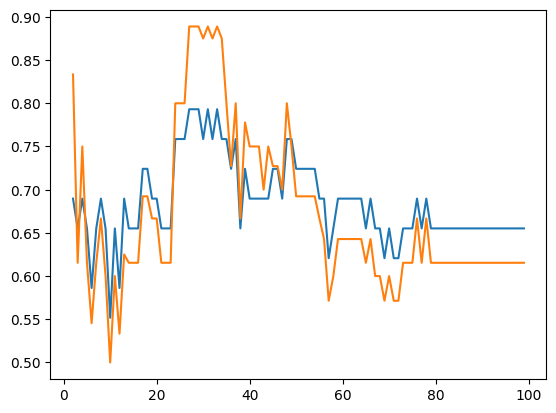

In [188]:
acc_list = []
prec_list = []
for i in range(2,100):
    rf = RandomForestClassifier(min_samples_split = 4, n_estimators=i, random_state = 42)
    acc, prec = make_predictions(predictors, rf)
    acc_list.append(acc)
    prec_list.append(prec)
plt.plot(range(2,100), acc_list)
plt.plot(range(2,100), prec_list)


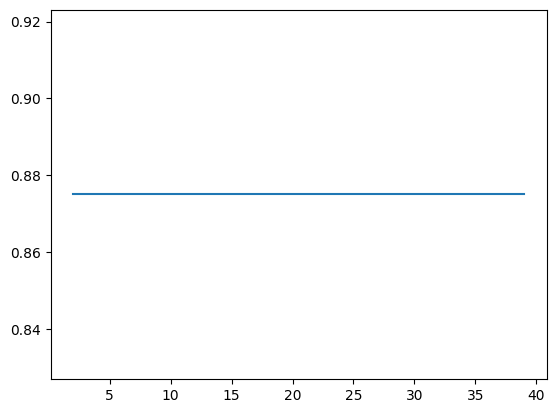

In [160]:
rf = RandomForestClassifier(min_samples_split = 4, n_estimators=30, random_state = 42)
acc, prec = make_predictions(predictors, rf)
acc

0.7586206896551724

In [161]:
prec

0.875

0.55 with random forest
